In [2]:
import mplfinance as mpf
import pandas as pd
import yfinance
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pyfolio as pf
import seaborn as sns
import pandas_ta as ta
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12,
                     'axes.labelweight': 'bold',
                     'figure.figsize': (8,6)})

C:\Users\WINDOWS\anaconda3\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [189]:
df = pd.DataFrame()
df = df.ta.ticker("^SET.bk", period = "23mo", interval = "1h")

df1 = df[['Open', 'High', 'Low', 'Close']]
df1

,Open,High,Low,Close
2020-02-12 10:00:00+07:00,1531.400024,1536.349976,1529.500000,1535.920044
2020-02-12 11:00:00+07:00,1536.250000,1537.660034,1534.339966,1534.520020
2020-02-12 12:00:00+07:00,1534.589966,1537.160034,1534.469971,1534.469971
2020-02-12 14:00:00+07:00,1534.469971,1537.709961,1534.469971,1536.170044
2020-02-12 15:00:00+07:00,1536.760010,1541.479980,1536.079956,1541.239990
...,...,...,...,...
2022-01-11 11:00:00+07:00,1663.359985,1665.729980,1661.939941,1662.449951
2022-01-11 12:00:00+07:00,1663.140015,1664.219971,1661.920044,1663.969971
2022-01-11 14:00:00+07:00,1663.969971,1664.660034,1661.479980,1662.369995
2022-01-11 15:00:00+07:00,1662.520020,1665.000000,1661.390015,1665.000000


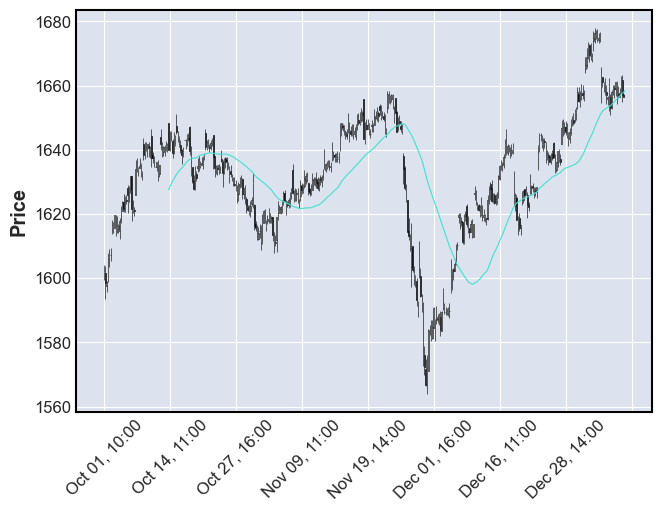

In [182]:
mpf.plot(df1.loc['2021-10':],type='candle',mav=50)

## Setup

In [183]:
def calcBollingerBand(data, periods=20, m=2, label=None):
  '''Calculates Bollinger Bands'''
  keys = ['UBB', 'LBB', 'TP', 'STD', 'TP_SMA']
  if label is None:
    ubb, lbb, tp, std, tp_sma = keys
  else:
    ubb, lbb, tp, std, tp_sma = [i + '_' + label for i in keys]
  data[tp] = data.apply(
    lambda x: np.mean(x[['High', 'Low', 'Close']]), axis=1)
  data[tp_sma] = data[tp].rolling(periods).mean()
  data[std] = data[tp].rolling(periods).std(ddof=1)
  data[ubb] = data[tp_sma] + m * data[std]
  data[lbb] = data[tp_sma] - m * data[std]
  return data

In [184]:
def calcReturns(df):
  # Helper function to avoid repeating too much code
  df['returns'] = df['Close'] / df['Close'].shift(1)
  df['log_returns'] = np.log(df['returns'])
  df['strat_returns'] = df['position'].shift(1) * df['returns']
  df['strat_log_returns'] = df['position'].shift(1) * \
    df['log_returns']
  df['cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1
  df['strat_cum_returns'] = np.exp(df['strat_log_returns'].cumsum()) - 1  
  return df

In [185]:
def BBBreakout(data, periods=20, m=1, shorts=True):
  '''
  Buy/short when price moves outside of the upper band.
  Exit when the price moves into the band.
  '''
  data = calcBollingerBand(data, periods, m)
  data['position'] = np.nan
  data['position'] = np.where(data['Close']>data['UBB'], 1, 0)
  if shorts:
    data['position'] = np.where(data['Close']<data['LBB'], -1,data['position'])
  data['position'] = data['position'].ffill().fillna(0)
  return data

In [186]:
# Run  our strategy
df_break = BBBreakout(df1.copy(),m = 0.5,shorts=False)

In [187]:
df_break = calcReturns(df_break)

### Save Data

In [10]:
#df_break.to_csv('full_tradingdata.csv')

### Performance

Start date,2020-02-06
End date,2022-01-06
Total months,131
,Backtest
Annual return,4.271%
Cumulative returns,58.315%
Annual volatility,4.967%
Sharpe ratio,0.87
Calmar ratio,0.56
Stability,0.94
Max drawdown,-7.591%


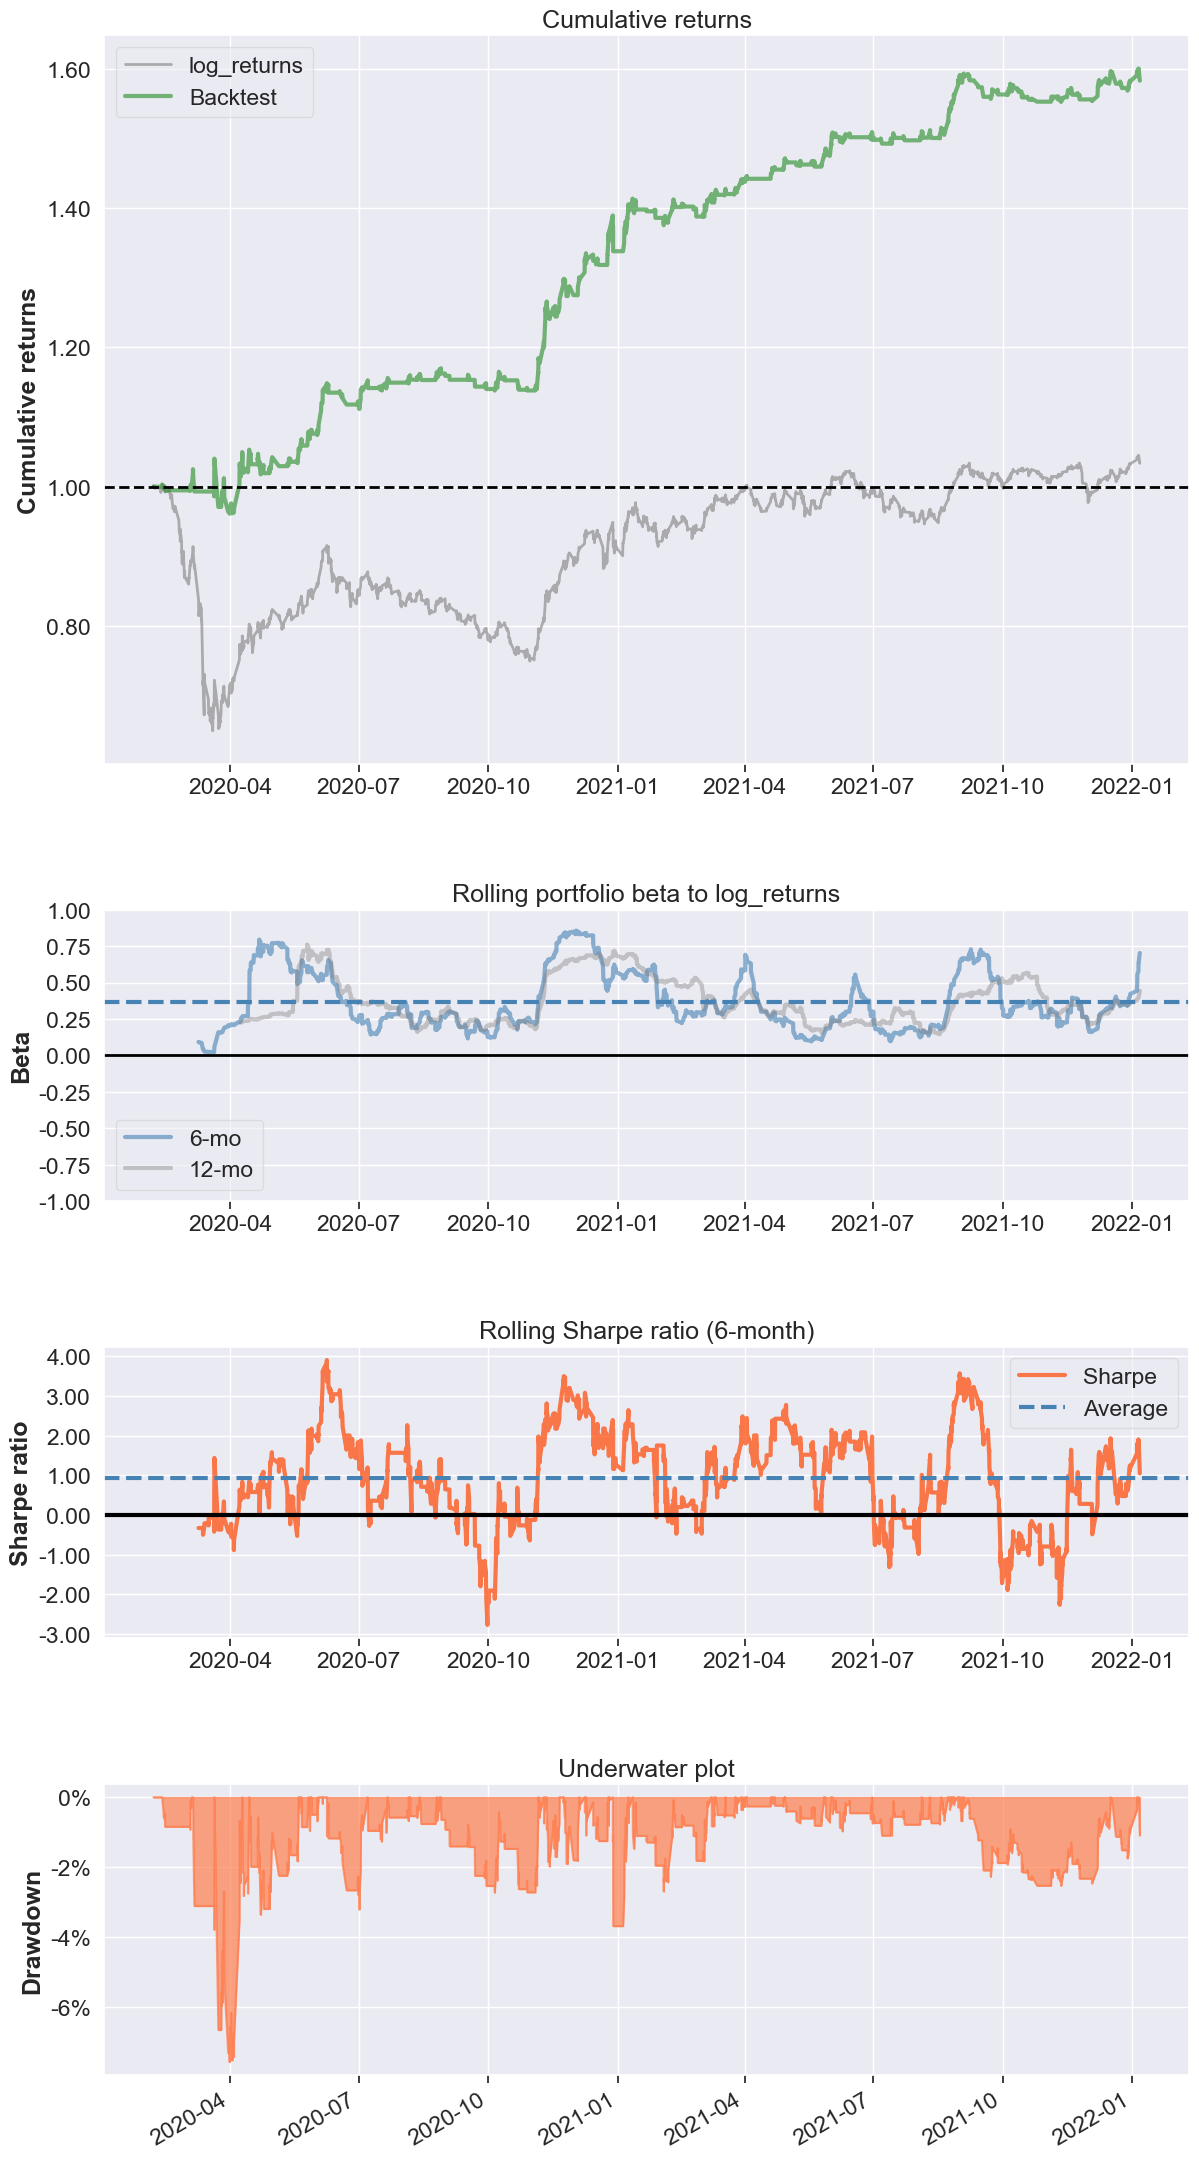

In [178]:
pf.create_simple_tear_sheet(df_break['strat_log_returns'],benchmark_rets=df_break['log_returns'])

เราจะไม่ predict return โดยตรงเช่นราคาจะขึ้นลงกี่เปอเซนต์ เพราะเป็นการ Predict base on stationary variable ซึ่งมันเสีย memory ไปเยอะ ทำให้โอกาสที่จะทำสำเร็จค่อนข้างต่ำ
จึงเปลี่ยนมาเป็นใช้ frame problem strategy จาก Regression เป็นในรูบ Classification แทน เพื่อพัฒนากลยุทธ์ต่อไป 

### Create Position Data

In [12]:
action_data = df_break.copy()

In [13]:
action_data['action_price'] = action_data['Open'].shift(-1)

In [14]:
action_data = action_data[['Open', 'High', 'Low', 'Close', 'UBB', 'LBB', 'position', 'action_price']]

In [15]:
action_data['helper'] = action_data.position.shift(1)

In [16]:
action_data = action_data.loc[action_data['helper']!=action_data['position']]
action_data['return'] = action_data['action_price'].pct_change()
action_data = action_data.iloc[1:]

In [17]:
action_data.reset_index(inplace=True)

In [18]:
action_data['previous_sig_date'] = action_data['index'].shift(1)
action_data['previous_action'] = action_data['position'].shift(1)
action_data['previous_act_price'] = action_data['action_price'].shift(1)
action_data.rename(columns={'index':'today_sig_date'}, inplace=True)

action_data

,today_sig_date,Open,High,Low,Close,UBB,LBB,position,action_price,helper,return,previous_sig_date,previous_action,previous_act_price
0,2020-02-12 14:00:00+07:00,1534.469971,1537.709961,1534.469971,1536.170044,1535.745662,1532.296334,1,1536.760010,0.0,-0.000052,NaT,NaN,NaN
1,2020-02-13 10:00:00+07:00,1539.689941,1541.869995,1533.290039,1535.510010,1536.310875,1532.467128,0,1535.930054,1.0,-0.000540,2020-02-12 14:00:00+07:00,1.0,1536.760010
2,2020-02-13 12:00:00+07:00,1535.109985,1539.449951,1534.520020,1537.040039,1536.223630,1532.425365,1,1537.040039,0.0,0.000723,2020-02-13 10:00:00+07:00,0.0,1535.930054
3,2020-02-13 14:00:00+07:00,1537.040039,1537.420044,1533.479980,1533.979980,1536.194935,1532.403059,0,1533.739990,1.0,-0.002147,2020-02-13 12:00:00+07:00,1.0,1537.040039
4,2020-02-14 10:00:00+07:00,1536.479980,1539.920044,1536.020020,1538.180054,1536.235742,1532.339925,1,1538.140015,0.0,0.002869,2020-02-13 14:00:00+07:00,0.0,1533.739990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021-12-24 14:00:00+07:00,1637.630005,1638.510010,1636.130005,1636.260010,1637.142722,1629.650938,0,1637.349976,1.0,-0.002194,2021-12-23 10:00:00+07:00,1.0,1640.949951
230,2021-12-24 15:00:00+07:00,1637.349976,1639.030029,1635.469971,1638.890015,1637.649006,1630.285992,1,1638.579956,0.0,0.000751,2021-12-24 14:00:00+07:00,0.0,1637.349976
231,2021-12-24 16:00:00+07:00,1638.579956,1639.969971,1636.829956,1637.339966,1638.131337,1630.901992,0,1642.069946,1.0,0.002130,2021-12-24 15:00:00+07:00,1.0,1638.579956
232,2021-12-28 10:00:00+07:00,1641.739990,1649.170044,1641.739990,1646.829956,1640.698153,1636.712516,1,1647.709961,0.0,0.003435,2021-12-24 16:00:00+07:00,0.0,1642.069946


In [19]:
action_data = action_data[['position','today_sig_date', 'Close', 'action_price', 'return', 'previous_sig_date', 'previous_action', 'previous_act_price']]

In [20]:
action_data = action_data[:-1]

In [21]:
action_data

,position,today_sig_date,Close,action_price,return,previous_sig_date,previous_action,previous_act_price
0,1,2020-02-12 14:00:00+07:00,1536.170044,1536.760010,-0.000052,NaT,NaN,NaN
1,0,2020-02-13 10:00:00+07:00,1535.510010,1535.930054,-0.000540,2020-02-12 14:00:00+07:00,1.0,1536.760010
2,1,2020-02-13 12:00:00+07:00,1537.040039,1537.040039,0.000723,2020-02-13 10:00:00+07:00,0.0,1535.930054
3,0,2020-02-13 14:00:00+07:00,1533.979980,1533.739990,-0.002147,2020-02-13 12:00:00+07:00,1.0,1537.040039
4,1,2020-02-14 10:00:00+07:00,1538.180054,1538.140015,0.002869,2020-02-13 14:00:00+07:00,0.0,1533.739990
...,...,...,...,...,...,...,...,...
228,1,2021-12-23 10:00:00+07:00,1641.130005,1640.949951,0.011427,2021-12-20 10:00:00+07:00,0.0,1622.410034
229,0,2021-12-24 14:00:00+07:00,1636.260010,1637.349976,-0.002194,2021-12-23 10:00:00+07:00,1.0,1640.949951
230,1,2021-12-24 15:00:00+07:00,1638.890015,1638.579956,0.000751,2021-12-24 14:00:00+07:00,0.0,1637.349976
231,0,2021-12-24 16:00:00+07:00,1637.339966,1642.069946,0.002130,2021-12-24 15:00:00+07:00,1.0,1638.579956


In [22]:
action_data.columns = ['action', 'today_sig_date','Close','action_price', 'return',
       'previous_sig_date', 'previous_action', 'previous_act_price']

In [23]:
position_data = action_data[action_data['action']==0].reset_index(drop=True)

In [24]:
position_data = position_data[['today_sig_date','previous_sig_date','Close','action_price','previous_act_price','return']]

In [25]:
#Gap action_price - Close
position_data['gap_size'] = position_data['action_price'] - position_data['Close']

In [26]:
#Duration previous_sig_date - today_sig_date
position_data['Holding_period'] = position_data['previous_sig_date'] - position_data['today_sig_date']

In [27]:
def convert_to_hours(delta):
    total_seconds = delta.total_seconds()
    hours = str(int(total_seconds // 3600))
    return hours

In [28]:
# convert to time delta Hours
position_data['Holding_period'] = position_data['Holding_period'].apply(convert_to_hours).str.replace('-',' ').astype('int')

#### Save

In [29]:
#position_data.to_csv('position_data.csv')

### Explore position data

In [30]:
position_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,116.0,1470.458961,158.823709,1058.239990,1337.932526,1532.979980,1617.649994,1650.609985
action_price,116.0,1470.737327,159.129140,1057.920044,1338.032501,1532.929993,1618.259979,1656.160034
previous_act_price,116.0,1464.711468,160.993855,1075.119995,1336.907471,1528.505005,1598.267517,1657.839966
return,116.0,0.004406,0.015184,-0.019409,-0.002159,-0.000302,0.005816,0.093723
gap_size,116.0,0.278366,2.032235,-8.970093,-0.262512,0.000000,0.315033,9.199951
Holding_period,116.0,57.474138,58.479348,1.000000,15.000000,46.000000,81.000000,287.000000


<AxesSubplot:>

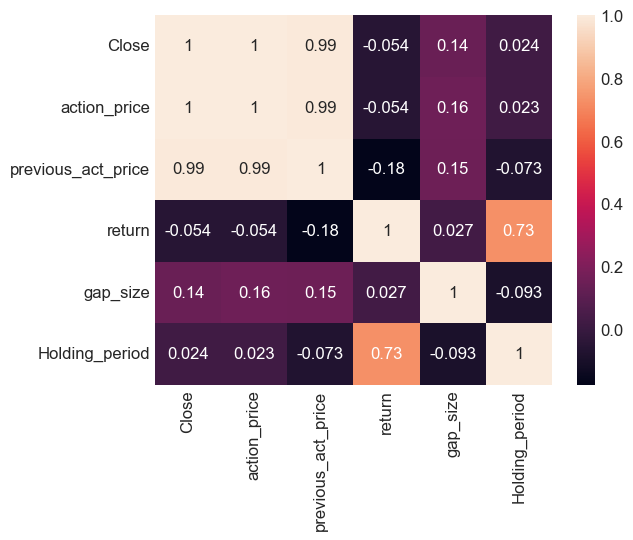

In [31]:
sns.heatmap(position_data.corr(), annot = True)

<AxesSubplot:xlabel='Holding_period', ylabel='Count'>

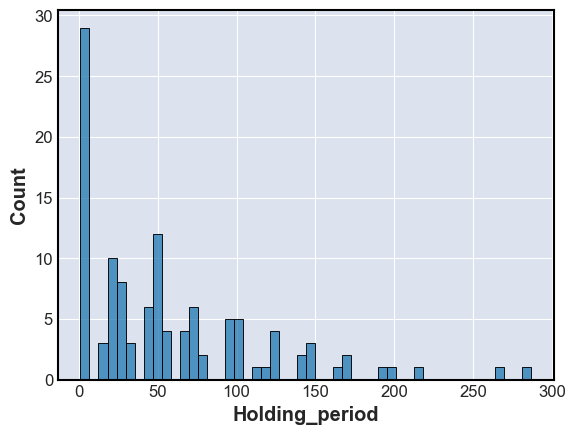

In [32]:
sns.histplot(position_data.Holding_period,bins = 50)

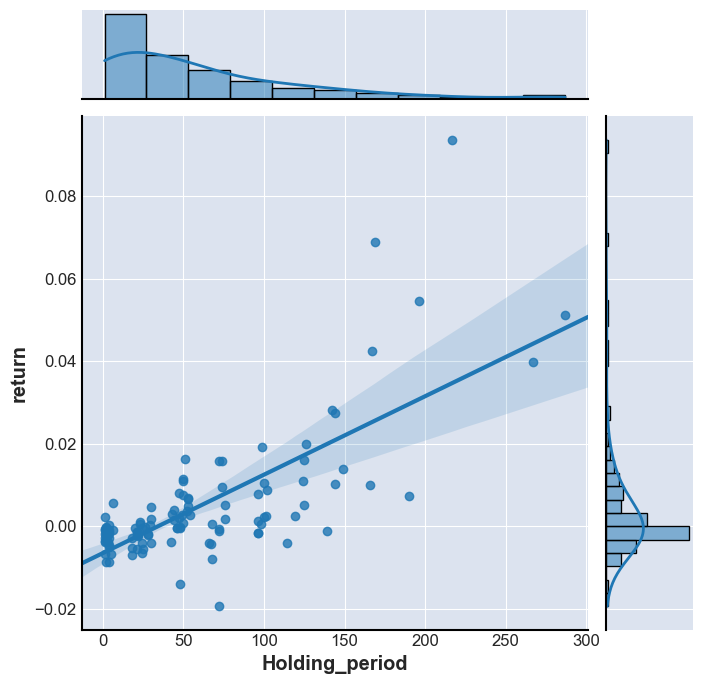

In [33]:
sns.jointplot(x=position_data.Holding_period, y= position_data['return'],kind="reg", truncate=False, height=7)

In [34]:
win = position_data[position_data['return'] > 0].shape[0]
print(f"Win {win} Order")

Win 55 Order


In [35]:
loss = position_data[position_data['return'] < 0].shape[0]
print(f"Loss {loss} Order")

Loss 61 Order


In [36]:
print(f"%Win {win/position_data.shape[0]*100}")

%Win 47.41379310344828


### Feature Selection

จากข้อมูลจะเห็นว่า มี False Breakeout บ่อยมาก 
เเต่ก็ขาดทุนทีละน้อยเช่นกัน

หาตัว filter มา remove noise 

Trend: MACD MA50DIFF ADX RegSlope
Momentum: CCI RSI Stoch%k
Volatility: NATR STD TrueRange 

In [37]:
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [4]:
help(ta.stoch)

Help on function stoch in module pandas_ta.momentum.stoch:

stoch(high, low, close, k=None, d=None, smooth_k=None, mamode=None, offset=None, **kwargs)
    Stochastic (STOCH)
    
    The Stochastic Oscillator (STOCH) was developed by George Lane in the 1950's.
    He believed this indicator was a good way to measure momentum because changes in
    momentum precede changes in price.
    
    It is a range-bound oscillator with two lines moving between 0 and 100.
    The first line (%K) displays the current close in relation to the period's
    high/low range. The second line (%D) is a Simple Moving Average of the %K line.
    The most common choices are a 14 period %K and a 3 period SMA for %D.
    
    Sources:
        https://www.tradingview.com/wiki/Stochastic_(STOCH)
        https://www.sierrachart.com/index.php?page=doc/StudiesReference.php&ID=332&Name=KD_-_Slow
    
    Calculation:
        Default Inputs:
            k=14, d=3, smooth_k=3
        SMA = Simple Moving Average
     

#### Load Data

In [39]:
tradingdata = pd.read_csv('full_tradingdata.csv')
tradingdata.rename(columns = {'Unnamed: 0':'date'}, inplace = True)
position_data = pd.read_csv('position_data.csv').iloc[:,1:]

In [40]:
tradingdata = tradingdata[['date', 'Open', 'High', 'Low', 'Close', 'UBB', 'position']]

#### add trend indicator feature

In [41]:
# MACD
tradingdata[['_macd','_hist','_sig']]= ta.macd(tradingdata['Close'])
tradingdata.drop(columns = '_sig',inplace = True)

In [42]:
# EMA50diff Percentage
tradingdata['_ema50diff'] = (tradingdata['Close'] - ta.ema(tradingdata['Close'],50))/ tradingdata['Close']

In [43]:
# ADX
tradingdata['_adx'] = ta.adx(tradingdata['High'],tradingdata['Low'],tradingdata['Close']).iloc[:,:1]

In [44]:
# Slope
tradingdata['_slope'] = ta.slope(tradingdata['Close'], 50)

In [45]:
# CCI
tradingdata['_cci'] = ta.cci(tradingdata['High'], tradingdata['Low'], tradingdata['Close'])

In [46]:
# RSI
tradingdata['_rsi'] = ta.rsi(tradingdata['Close'])

In [47]:
# Stoch
tradingdata['_stochK'] = ta.stoch(tradingdata['High'], tradingdata['Low'], tradingdata['Close']).iloc[:,:1]

In [48]:
# NATR
tradingdata['_natr'] = ta.natr(tradingdata['High'], tradingdata['Low'], tradingdata['Close'])

In [49]:
# Stdev
tradingdata['_stdev'] = ta.stdev(tradingdata['Close'])

In [50]:
tradingdata['_truerange'] =  ta.true_range(tradingdata['High'], tradingdata['Low'], tradingdata['Close'])

In [51]:
tradingdata.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'UBB', 'position', '_macd',
       '_hist', '_ema50diff', '_adx', '_slope', '_cci', '_rsi', '_stochK',
       '_natr', '_stdev', '_truerange'],
      dtype='object')

#### Merge with previous_sig_date(buy date)

In [52]:
full_position_data = position_data.merge(tradingdata[['date', '_macd','_hist', '_ema50diff', '_adx', '_slope', '_cci', '_rsi', '_stochK','_natr', '_stdev', '_truerange']],
                    left_on = 'previous_sig_date', right_on = 'date')

In [53]:
full_position_data.dropna(inplace = True)

- today_sig_date = วันที่ขาย
- previous_sig_date, date = วันที่ซื้อ
- action_price = ราคาที่ขาย (ราคาเปิดวันถัดไปหลังเกิด Sig)
- previous_act_price = ราคาทีซื้อ (ราคาเปิดวันถัดไปหลังเกิด Sig)

In [54]:
full_position_data

,today_sig_date,previous_sig_date,Close,action_price,previous_act_price,return,gap_size,Holding_period,date,_macd,_hist,_ema50diff,_adx,_slope,_cci,_rsi,_stochK,_natr,_stdev,_truerange
3,2020-02-13 14:00:00+07:00,2020-02-13 12:00:00+07:00,1533.979980,1533.739990,1537.040039,-0.002147,-0.239990,2,2020-02-13 12:00:00+07:00,3.186761,-0.320892,0.007481,15.960791,0.301602,58.200770,55.731938,65.720522,0.348456,4.732513,4.929932
4,2020-02-14 14:00:00+07:00,2020-02-14 10:00:00+07:00,1533.939941,1533.790039,1538.140015,-0.002828,-0.149902,4,2020-02-14 10:00:00+07:00,2.211963,-0.603108,0.007370,13.500945,0.437600,75.573370,56.747141,58.441256,0.340953,3.693146,7.900024
5,2020-03-06 10:00:00+07:00,2020-03-03 10:00:00+07:00,1364.680054,1364.689941,1366.390015,-0.001244,0.009888,72,2020-03-03 10:00:00+07:00,-20.915739,4.652543,-0.026961,48.610959,-2.795798,102.804212,48.431954,36.824564,1.117975,35.266712,28.869995
6,2020-03-23 10:00:00+07:00,2020-03-20 10:00:00+07:00,1058.239990,1057.920044,1078.859985,-0.019409,-0.319946,72,2020-03-20 10:00:00+07:00,-20.543666,8.813702,-0.039004,32.854949,-3.566201,157.886405,52.685669,67.383957,1.935136,31.910718,37.040039
7,2020-03-27 15:00:00+07:00,2020-03-25 12:00:00+07:00,1091.959961,1092.699951,1075.119995,0.016352,0.739990,51,2020-03-25 12:00:00+07:00,-3.630090,4.450923,-0.010178,16.273819,0.593799,159.493094,55.582292,77.965078,1.626757,28.251142,6.880005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2021-12-09 15:00:00+07:00,2021-12-03 10:00:00+07:00,1613.290039,1612.849976,1590.900024,0.013797,-0.440063,149,2021-12-03 10:00:00+07:00,-6.721420,2.993230,-0.009741,37.960744,-1.200200,129.199620,46.545551,82.245097,0.467027,14.666411,7.369995
114,2021-12-14 10:00:00+07:00,2021-12-09 16:00:00+07:00,1619.569946,1619.449951,1626.150024,-0.004120,-0.119995,114,2021-12-09 16:00:00+07:00,5.045193,0.120213,0.004965,25.228582,0.050000,-0.948802,59.975459,65.227801,0.348291,12.800761,4.000000
115,2021-12-20 10:00:00+07:00,2021-12-14 15:00:00+07:00,1623.390015,1622.410034,1624.310059,-0.001170,-0.979980,139,2021-12-14 15:00:00+07:00,4.010479,-0.620094,0.006881,23.810028,0.635801,60.336016,61.814725,49.676139,0.313329,8.360356,7.930054
116,2021-12-24 14:00:00+07:00,2021-12-23 10:00:00+07:00,1636.260010,1637.349976,1640.949951,-0.002194,1.089966,28,2021-12-23 10:00:00+07:00,1.185893,1.127458,0.009625,19.996021,0.556799,280.174118,66.603036,83.320809,0.330094,8.080482,13.079956


<AxesSubplot:xlabel='return', ylabel='_stdev'>

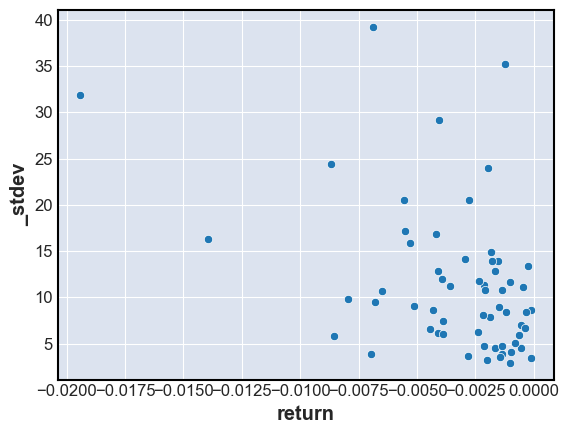

In [55]:
sns.scatterplot(full_position_data[full_position_data['return'] < 0]['return'],full_position_data['_stdev'])

In [176]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler
# these classifiers contain either coef_ or feature_importances_ attribute.
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import ExtraTreesClassifier

from sklearn import metrics

In [177]:
full_position_data['target'] = np.where(full_position_data['return'] > 0, 1, 0)

In [58]:
full_position_data.columns

Index(['today_sig_date', 'previous_sig_date', 'Close', 'action_price',
       'previous_act_price', 'return', 'gap_size', 'Holding_period', 'date',
       '_macd', '_hist', '_ema50diff', '_adx', '_slope', '_cci', '_rsi',
       '_stochK', '_natr', '_stdev', '_truerange', 'target'],
      dtype='object')

In [164]:
cols=['_macd', '_hist', '_ema50diff', '_adx', '_slope', '_cci', '_rsi',
       '_stochK', '_natr', '_stdev', '_truerange']
X=full_position_data[cols]
y=full_position_data['target']

test_size=.2
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=7)

In [165]:
param_grid = { 
    'n_estimators': [100,200,300,400,500,600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,3,4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

In [166]:
rf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(estimator=rf, param_grid = param_grid, cv = 5)

In [167]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500, 600]})

In [168]:
rf_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'n_estimators': 100}

In [169]:
rf1 = RandomForestClassifier(max_features='auto', n_estimators= 100, criterion='entropy', max_depth = 3)
rf1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3)

In [170]:
trainscore = rf1.score(X_train, y_train)
testscore = rf1.score(X_test, y_test)
y_pred=rf1.predict(X_test)

print(f'Train data score: {trainscore:.04f}')
print(f'Test data score: {testscore:.04f}')
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Train data score: 0.9130
Test data score: 0.6087
[[8 3]
 [6 6]]
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.67      0.50      0.57        12

    accuracy                           0.61        23
   macro avg       0.62      0.61      0.61        23
weighted avg       0.62      0.61      0.60        23



### Feature importance by Randomforest

In [171]:
fs=pd.Series(rf1.feature_importances_, index=cols).sort_values(ascending=True)
fs

_ema50diff    0.037190
_rsi          0.054734
_macd         0.065746
_natr         0.067605
_hist         0.069500
_adx          0.081811
_stdev        0.097331
_cci          0.108940
_slope        0.109503
_stochK       0.141794
_truerange    0.165846
dtype: float64

<AxesSubplot:>

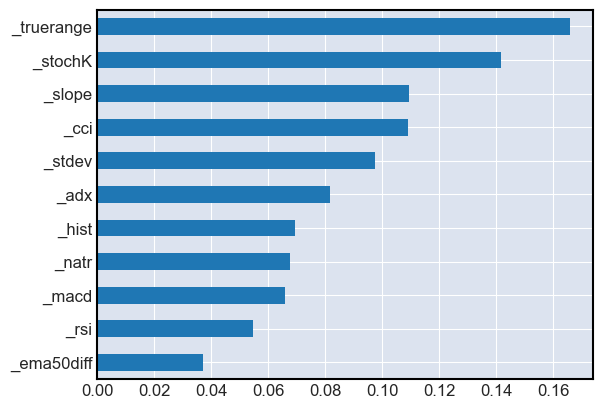

In [172]:
fs.plot(kind = 'barh')

### shap explainer and feature impact

In [173]:
import shap
explainer = shap.TreeExplainer(rf1)
shap_values = np.array(explainer.shap_values(X_train))
print(shap_values.shape)

(2, 92, 11)


2 : number of classes. 
92 : number of datapoints. We have local SHAP values per datapoint.
12 : number of features. We have SHAP value per every feature.

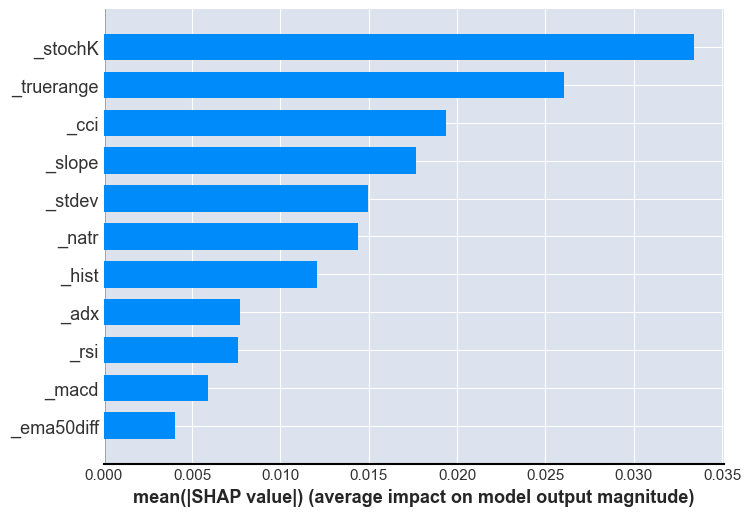

In [174]:
shap.summary_plot(shap_values[1], X_train, plot_type="bar",feature_names = cols)

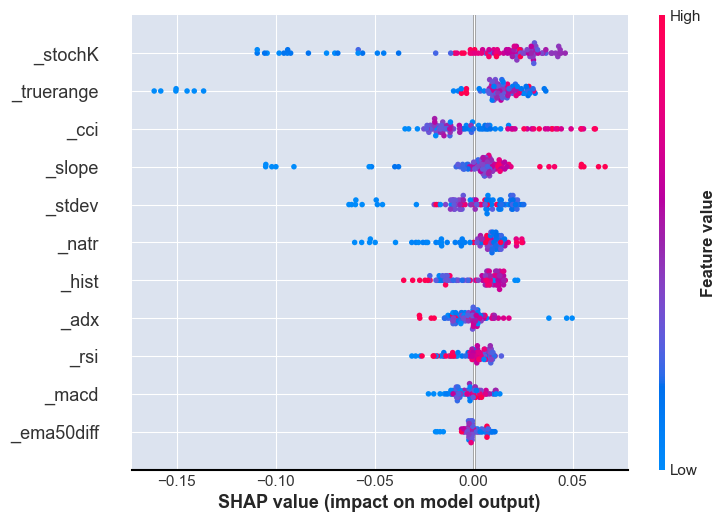

In [175]:
shap.summary_plot(shap_values[1], X_train,feature_names = cols)